# Assignment 6

In this assignment, you will train a network to recognize musical notes!

### The Task

I recorded myself playing my daughter's toy xylophone shown below.  Given a short $.75$ second-long recording of a single note (beginning at its onset), you will train a neural network to predict which note is being played.  For the purposes of this assignment, you may assume that a note onset has already been detected, and your goal is simply to predict which of the eight notes is being played.

<img src='xylophone.jpg' width='400'>

### The Data

The raw data consists of:
- 8 .mp3 files, each containing about 125 note onsets.  Each audio recording contains only one note value (i.e. I was hitting the same note again and again), and the note onsets are separated by approximately 1 second.
- 8 .csv files which contain manual annotations of the note onsets in seconds.

I recommend using the python package librosa for reading in and processing the audio data.

### The Deliverables

You will turn in two things:
- A jupyter notebook named "firstname-lastname.ipynb" containing all of your work.  Please make sure that all of the code cells have been executed, that the output results and plots are showing, and that the notebook executes without any errors.

- A two page report describing your approach, experimental results, and any insights or rationale that guided the process of designing your solution.  Your report should include relevant plots and figures.

### The Rules

A few ground rules:
- You must work individually.  There is no collaboration allowed on this assignment.  You should think of this assignment as a midterm.
- You may use any relevant online resources.
- You may use any previous materials that I have released to the class, or any previous homework submissions you have done yourself.
- You must use pyTorch to train your neural network.  You may also use numpy, librosa, or any other relevant software packages as needed.
- You may use any concepts covered in this class so far, or any material from E207.  In particular, you are encouraged to explore ways to reduce the dimensionality of the input by considering different time-frequency representations of the audio signal.

### The Rubric

You will be graded using the following rubric:
- Audio is extracted from the .mp3 files properly (10 points).
- The data is split into train, validation, and test sets (5 points).  The test set should contain 20% of the data.
- The raw audio signals are converted to a format that is well suited to training (10 points).  Reasons are given for selecting the chosen representation of audio.
- The pre-processed data is packaged into pyTorch data loaders (5 points).
- Neural network model is defined in pyTorch correctly (5 points).  The model should have at least one hidden layer.
- Function for training the model is defined and implemented correctly (20 points).  The function should train for multiple epochs, and it should keep track of training loss, validation loss, and validation accuracy.
- Plot showing the training loss and validation loss vs training epochs (10 points).  This plot should show that the network has converged to a good solution and is not overfitting the data.
- Function for evaluating the trained model on the test data is defined and implemented correctly (10 points).  The function should indicate the test loss and test accuracy, and the performance should be close to perfect.
- Plot showing the effect of one hyperparameter of interest on system performance (10 points).
- Code decomposition and readability (5 points).  The code should be well decomposed, easy to read, and well commented.
- Writing quality (10 pts).  The report should be written in a clear and succinct manner.  The plots should be well-labeled and easy to understand.

### Import libraries

In [4]:
import numpy as np
import csv
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

### Data Preparation

In [5]:
#Make a path
path = os.path.abspath(os.getcwd()) + '/raw_data'
#Check what the sample data looks like
ipd.Audio(path+'/class1.mp3')

In [6]:
#Load the eight classes as series with the same sample rates sr
y1,sr = lb.core.load(path+'/class1.mp3')
y2,sr = lb.core.load(path+'/class2.mp3')
y3,sr = lb.core.load(path+'/class3.mp3')
y4,sr = lb.core.load(path+'/class4.mp3')
y5,sr = lb.core.load(path+'/class5.mp3')
y6,sr = lb.core.load(path+'/class6.mp3')
y7,sr = lb.core.load(path+'/class7.mp3')
y8,sr = lb.core.load(path+'/class8.mp3')

/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread i

In [7]:
"""
Function: Creates tuples of indexes corresponding to the beginning and end index of all notes in a sampled signal
Inputs: File with onset timings
Outputs: Tuple of onset indexes and note end indexes
"""
def generateOnsets(filename):
    #Create a list to hold the start and end index of each note
    onsets = []
    #Iterate the csv with the onsets
    with open(path + filename) as csvfile:
        #Read the csv row by row
        reader = csv.reader(csvfile)
        for row in reader:
            #Based on the given task, make a tuple with the onset and the index 0.75 seconds after the onset
            onsets.append([int(float(row[0])*sr), int((float(row[0]) + 0.75)*sr)])
    return onsets

#### Format for the audio. I'm choosing to compute chroma features to keep the dimensionality of the inputs low while also retaining information about the frequency content of our notes. Computing the STFT instead would be more efficient for creating the dataset, but would need a more complicated NN down the line; the STFT produces window_size/2 frequency bins while chroma features only produce 12 features for frequency content. If the NN is unable to learn frequency content from the chromas, this choice can be revisited  

In [8]:
"""
Function: Create chroma samples for each note
Inputs: Tuple with onset indexes and note end indexes
        Signal to calculate chroma features from
Outputs: Array of chroma features. Each element is the chroma features for a given note
"""
def createChromaSamples(onsets, data):
    #Create a list to hold the chroma features
    classChromas = []
    for x in onsets:
        #Slice the data 
        sample = data[x[0]:x[1]]
        #Calculate chroma features
        sample_chromas = lb.feature.chroma_cens(y=sample, sr=sr).flatten()
        classChromas.append(sample_chromas.astype(float))
    return np.array(classChromas)

In [9]:
#Run functions to preprocess the data. Takes a long while

#First, get the note start and end tuple for each csv
onsets1 = generateOnsets('/class1.csv')
onsets2 = generateOnsets('/class2.csv')
onsets3 = generateOnsets('/class3.csv')
onsets4 = generateOnsets('/class4.csv')
onsets5 = generateOnsets('/class5.csv')
onsets6 = generateOnsets('/class6.csv')
onsets7 = generateOnsets('/class7.csv')
onsets8 = generateOnsets('/class8.csv')

#Next, calculate the chroma features for each class
chromas1 = createChromaSamples(onsets1, y1)
chromas2 = createChromaSamples(onsets2, y2)
chromas3 = createChromaSamples(onsets3, y3)
chromas4 = createChromaSamples(onsets4, y4)
chromas5 = createChromaSamples(onsets5, y5)
chromas6 = createChromaSamples(onsets6, y6)
chromas7 = createChromaSamples(onsets7, y7)
chromas8 = createChromaSamples(onsets8, y8)

/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=517
  warnings.warn(
/home/marco/miniconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=259
  warnings.warn(


### Sanity check the chroma feature decision

Text(0, 0.5, 'Class 7')

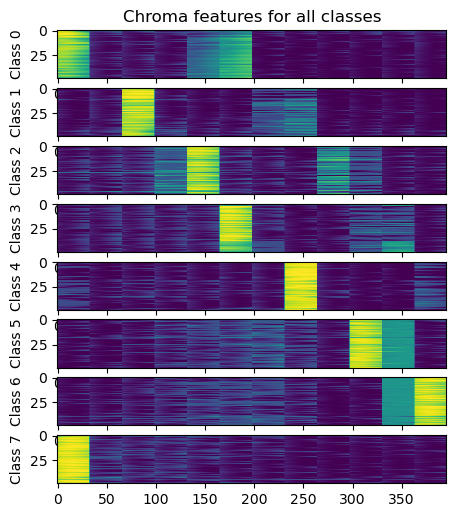

In [10]:
from matplotlib.pyplot import figure

#Create a figure to show 
figure(figsize=(8, 6), dpi=100)
ax1 = plt.subplot(8,1,1)
ax2 = plt.subplot(8,1,2)
ax3 = plt.subplot(8,1,3)
ax4 = plt.subplot(8,1,4)
ax5 = plt.subplot(8,1,5)
ax6 = plt.subplot(8,1,6)
ax7 = plt.subplot(8,1,7)
ax8 = plt.subplot(8,1,8)

ax1.imshow(chromas1[1:50][:])
ax1.set_title("Chroma features for all classes")
ax1.set_ylabel("Class 0")
ax2.imshow(chromas2[1:50][:])
ax2.set_ylabel("Class 1")
ax3.imshow(chromas3[1:50][:])
ax3.set_ylabel("Class 2")
ax4.imshow(chromas4[1:50][:])
ax4.set_ylabel("Class 3")
ax5.imshow(chromas5[1:50][:])
ax5.set_ylabel("Class 4")
ax6.imshow(chromas6[1:50][:])
ax6.set_ylabel("Class 5")
ax7.imshow(chromas7[1:50][:])
ax7.set_ylabel("Class 6")
ax8.imshow(chromas8[1:50][:])
ax8.set_ylabel("Class 7")

#### As expected, different classes produce different chromas, and chromas look similar within the same class

In [11]:
#Make labels for the classes. The label shape must match the number of notes in each class

#The value of each element in the label should be the class number
labels1 = np.zeros((chromas1.shape[0])) 
labels2 = np.ones((chromas2.shape[0])) * 1
labels3 = np.ones((chromas3.shape[0])) * 2
labels4 = np.ones((chromas4.shape[0])) * 3
labels5 = np.ones((chromas5.shape[0])) * 4
labels6 = np.ones((chromas6.shape[0])) * 5
labels7 = np.ones((chromas7.shape[0])) * 6
labels8 = np.ones((chromas8.shape[0])) * 7

print("Check that the labels have the right shape")
print(labels1.shape)
print("yay")

Check that the labels have the right shape
(124,)
yay


In [12]:
#Make a tensor for the dataset and the labels
Dataset = torch.tensor(np.vstack((chromas1, chromas2, chromas3, chromas4, chromas5, chromas6, chromas7, chromas8)))
Labels = torch.tensor(np.hstack((labels1, labels2, labels3, labels4, labels5, labels6, labels7, labels8)))

In [13]:
#Make a dataset from our data
xylophone_dataset = TensorDataset(Dataset, Labels)

### Split dataset and create dataloaders

In [14]:
#Set the device as the gpu if there is one
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
#Adjust these ratios to change the length of the train, test, val set
#Currently, these are set so that the test is 20%
train_len = int(len(Dataset) * 0.6)
test_len = int(len(Dataset) * 0.2)
validation_len = len(Dataset)-(train_len+test_len)

In [26]:
#Randomly split the dataset into the test, validation, and train sets
train_set, val_set, test_set = torch.utils.data.random_split(xylophone_dataset, [train_len, validation_len, test_len])


#Also create the dataloaders
#First, declare a batch size
batch_size = 50
#Make a dataloader for each dataset
train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_DL = DataLoader(test_set, batch_size=batch_size, shuffle=True)
test_DL = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Sanity check that the dataloader works

In [27]:
#Grab a random element from the train dataloader to check that it is working as expected
image,label = [x[0] for x in iter(train_DL).next()]
#Running this many times gives new random values. Seems to work!
print(label)
print(image)

tensor(0., dtype=torch.float64)
tensor([7.5268e-01, 7.5192e-01, 7.5051e-01, 7.4845e-01, 7.4574e-01, 7.4236e-01,
        7.3833e-01, 7.3363e-01, 7.2825e-01, 7.2220e-01, 7.1545e-01, 7.0800e-01,
        6.9981e-01, 6.9089e-01, 6.8132e-01, 6.7117e-01, 6.6052e-01, 6.4944e-01,
        6.3800e-01, 6.2629e-01, 6.1440e-01, 6.0246e-01, 5.9059e-01, 5.7894e-01,
        5.6761e-01, 5.5665e-01, 5.4611e-01, 5.3601e-01, 5.2639e-01, 5.1723e-01,
        5.0854e-01, 5.0027e-01, 4.9238e-01, 9.9610e-02, 9.1936e-02, 8.4639e-02,
        7.7691e-02, 7.1064e-02, 6.4735e-02, 5.8681e-02, 5.2888e-02, 4.7341e-02,
        4.2033e-02, 3.6960e-02, 3.2125e-02, 2.7596e-02, 2.3447e-02, 1.9696e-02,
        1.6360e-02, 1.3459e-02, 1.1015e-02, 9.0557e-03, 7.6128e-03, 6.7246e-03,
        6.4358e-03, 6.7324e-03, 7.5327e-03, 8.6725e-03, 9.9618e-03, 1.1333e-02,
        1.2788e-02, 1.4330e-02, 1.5964e-02, 1.7697e-02, 1.9536e-02, 2.1492e-02,
        6.0415e-02, 5.5388e-02, 5.0651e-02, 4.6179e-02, 4.1948e-02, 3.7939e-02,
        

### Model

In [28]:
class Xylophone_classifier(nn.Module):
    def __init__(self, n1, n2, n3, n4, n5):
        super(Xylophone_classifier, self).__init__()
        #Linear layer sizes are set here
        self.lin1 = nn.Linear(n1,n2, bias=True)
        self.lin2 = nn.Linear(n2,n3, bias=True)
        self.lin3 = nn.Linear(n3,n4, bias=True)
        self.lin4 = nn.Linear(n4,n5, bias=True)
        #Dropout layers also included
        self.d1 = nn.Dropout(p=0.2)
        self.d2 = nn.Dropout(p=0.2)
        self.d3 = nn.Dropout(p=0.2)
        
#Describe forward path through net. x is input data
    def forward(self, x):
        #Pass data through linear layers
        x = self.lin1(x)
        x = F.relu(x) 
        x = self.d1(x)

        x = self.lin2(x)
        x = F.relu(x) 
        x = self.d2(x)
        
        x = self.lin3(x)
        x = F.relu(x) 
        x = self.d3(x)
        
        x = self.lin4(x)
        out = F.softmax(x, dim = 1)
        return out

In [29]:
"""
Function: Evaluate a trained model
Inputs: model: model to evaluate
        test_DL: Dataloader to use for evaluation

        
Outputs: Accuracy: Accuracy of the model on the given DL
"""
def evaluateModel(model, test_DL, verbose = True):
    #Put the model in eval mode
    model.eval()
    #Save numbers for the correct guesses, total, and incorrect
    correct = 0
    total = 0
    incorrect = 0
    #Also save misclassified samples for debugging net
    badPreds = []
    
    #Don't save gradients
    with torch.no_grad():
        #Iterate through the DL
        for data in test_DL:
            #Find the predictions on the data
            inputs, labels = data
            outputs = model(inputs.to(device).float())
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().numpy()
            labels = labels.numpy()
            #Iterate through labels
            for x in range(len(labels)):
                total +=1
                #If label doesn't match predictions, increment incorrect and save the sample for debugging
                if labels[x]!=predicted[x]:
                    incorrect +=1
                    badPreds.append([inputs[x], outputs.data[x], labels[x], predicted[x]])
                #Otherwise it's correct
                else:
                    correct +=1
    #Print out the accuracy if wanted
    if verbose:
        print('Accuracy of the network on the ' + str(total) + ' test images: %d %%' % (
            100 * correct / total))
    
    #Calculate accuracy and return it alongside mispredicted samples
    accuracy = correct / total
    return accuracy, badPreds

In [30]:
"""
Function: Train a model
Inputs: model: model to train
        train_DL: Dataloader for trainset
        valid_DL: Dataloader for valid set
        num_epochs: number of training epochs
        lr: learning rate
        lambd: regularization of loss function
        
Outputs: model: trained model
         losses: list of trainset losses over iterations
         vallosses: list of valid set losses over iterations
"""
def trainLoop(model, train_DL, val_DL, num_epochs, lr, lambd, verbose = True):
    #Declare the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, weight_decay = lambd)
    
    #Create lists to store losses for plotting later
    losses = []
    valLosses = []
    valAccuracy = []
    
    #Iterate for each epoch
    for epoch in range(num_epochs):
        
        #Make values to store loss and count samples
        total_loss = 0
        trainSamples = 0
        #Loop through the train loader
        for step, (data, labels) in enumerate(train_DL):
            #Send the data and labels to GPU
            inputs= data.to(device).float()
            labels = labels.to(device).long()
            #Zero gradients
            optimizer.zero_grad()
            #Find predictions and calculate loss on GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #Use Autograd to find gradients
            loss.backward()
            #Step with the gradients
            optimizer.step()
            #Store loss and count samples
            total_loss += loss.item()
            trainSamples += data.shape[0]

        #Find the validation loss
        #Make variables to store the loss and samples
        total_val_loss = 0  
        validSamples = 0
        #Set to eval mode for validation set and iterate through the valid dataloader
        model.eval()
        for step, (data, labels) in enumerate(val_DL):
            #Pass validation data to GPU
            inputs = data.to(device).float()
            labels = labels.to(device).long()
            #Forward pass to find loss. Use eval mode for valid set
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss +=loss.item()
            validSamples += data.shape[0]
        
        #Use eval function to find validation accuracy
        valAccuracy.append(evaluateModel(model, val_DL, verbose = False)[0])
        #return to train mode after finding validation accuracy and
        model.train()
        
        #Print out accuracies if wanted
        if epoch%100 ==0 and epoch !=0 and verbose ==True:
            print("Epoch: " + str(epoch)+ ". Average loss per training sample is: "+str(total_loss/trainSamples))
            print("Epoch: " + str(epoch)+ ". Average loss per valid sample is: "+str(total_val_loss/validSamples) + '\n')


        #Save losses per sample
        losses.append(total_loss/trainSamples)
        valLosses.append(total_val_loss/validSamples)
        
    return model, losses, valLosses, valAccuracy

In [31]:
"""
Function: Plot losses of a trained model
Inputs: val_loss: list of validation losses
        test_loss: list of test set losses

        
Outputs: N/a
"""
def plotLosses(val_loss, test_loss, valid_accuracy):
    #Setup subplots
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    #Label plots
    ax2.plot(val_loss, label = 'Validation loss')
    ax2.plot(test_loss, label = 'Test loss')
    ax1.plot(valid_accuracy, label = 'Validation Accuracy')
    ax1.set_xlabel("Iteration")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss per Sample")
    ax1.set_ylabel("Validation Accuracy")
    ax1.legend()
    ax2.legend()
    plt.show()

### Run the train loop, eval function, and plot

Epoch: 100. Average loss per training sample is: 0.02765257393901391
Epoch: 100. Average loss per valid sample is: 0.03168945914447898

Epoch: 200. Average loss per training sample is: 0.02735949485659403
Epoch: 200. Average loss per valid sample is: 0.031544740837399325

Epoch: 300. Average loss per training sample is: 0.02740403160428294
Epoch: 300. Average loss per valid sample is: 0.03154218019825397

Epoch: 400. Average loss per training sample is: 0.027353021811810513
Epoch: 400. Average loss per valid sample is: 0.03154272372179692



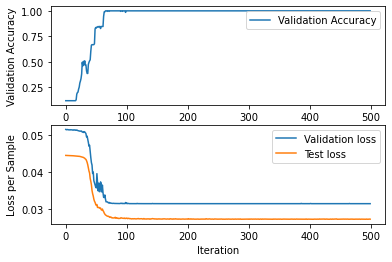

In [47]:
#Declare parameters for nn and training
num_epochs = 500
lr = 0.1
lambd = 0.001

n1 = Dataset.shape[1]
n2 = 256
n3 = 128
n4 = 64
n5 = 8

#Make the model
model = Xylophone_classifier(n1,n2,n3,n4,n5).to(device).train()
#Train the model
trained_model, losses, valid_losses, valid_accuracy = trainLoop(model, train_DL, val_DL, num_epochs, lr, lambd)
#Plot the results
plotLosses(valid_losses, losses, valid_accuracy)

In [48]:
#Use eval function to find accuracy
Accuracy, mistakes = evaluateModel(trained_model, test_DL)
print("Accuracy on the test dataset:")
print(Accuracy)

Accuracy of the network on the 204 test images: 99 %
Accuracy on the test dataset:
0.9950980392156863


### Iteration on design. Test the effect of one hyperparameter

I will try changing the amount of regularization as a hyperparameter to investigate model performance. I will run the same training procedure with many different weight decay values.

In [52]:
#For the plots to look right, num_epochs has to be high
#This is the case because some of the versions with lots of regularization are
#Are very slow to converge

#Set the epochs
num_epochs = 2000
#Set Learning rate
lr = 0.1
#Create an array of weight decay values to test
lambdas = [0, 0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]

#Make a list to hold the accuracies, mistakes, and weights for each lambda
accuracies = []
all_Mistakes = []
parameter_weights = []

#Define the model parameters. These are the same for all
n1 = Dataset.shape[1]
n2 = 256
n3 = 128
n4 = 64
n5 = 8

#Iterate through every weight decay value
for x in range(len(lambdas)):
    print("Testing lambda = " + str(lambdas[x]))
    #Make a new model
    model = Xylophone_classifier(n1,n2,n3,n4,n5).to(device).train()
    #Train the model with a new weight decay value
    trained_model, losses, valid_losses, valid_accuracy = trainLoop(model, train_DL, val_DL, num_epochs, lr, lambdas[x],  False)
    #Evaluate the trained model
    Accuracy, l_mistakes = evaluateModel(trained_model, test_DL)
    accuracies.append(Accuracy)
    #Keep track of mistakes for visualization later(optional)
    all_Mistakes.append(l_mistakes)
    #Calculate the L2 norm of the weights:
    total = 0
    for parameter in model.parameters():
        total = total + np.linalg.norm(parameter.cpu().detach().numpy())
    #Keep track of the norm for plotting
    parameter_weights.append(total)

Testing lambda = 0
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.0001
Accuracy of the network on the 204 test images: 100 %
Testing lambda = 0.001
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.002
Accuracy of the network on the 204 test images: 100 %
Testing lambda = 0.003
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.004
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.005
Accuracy of the network on the 204 test images: 100 %
Testing lambda = 0.006
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.007
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.008
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.009
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.01
Accuracy of the network on the 204 test images: 99 %
Testing lambda = 0.011
Accuracy of the network on the 204 test images: 14 %
Testing lambd

Plotting results

Text(0, 0.5, 'Test Set Accuracy')

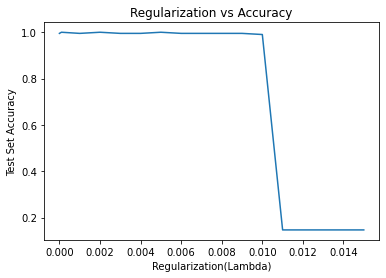

In [53]:
#Plot the regularizations and accuracies
plt.plot(lambdas, accuracies)
plt.title("Regularization vs Accuracy")
plt.xlabel("Regularization(Lambda)")
plt.ylabel("Test Set Accuracy")

Text(0, 0.5, 'Magnitude of Model Weights(L2 norm)')

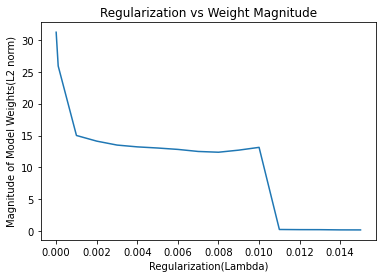

In [54]:
#Plot the L2 norms and regularization
plt.plot(lambdas, parameter_weights)
plt.title("Regularization vs Weight Magnitude")
plt.xlabel("Regularization(Lambda)")
plt.ylabel("Magnitude of Model Weights(L2 norm)")

### NN debug code

#### Depending on how training goes, the code below may not do anything. I used it to identify notes where my NN made incorrect predictions. The analyze mistakes function takes in mistakes returned by my evaluate model function and prints the mistake, confidence, and inputs. This code won't do anything if passed an empty list of mistakes(which can happen if training went differently on your machine)

In [55]:
"""
function: Look at any mistakes made when evaluating
Inputs: inference mistakes
Outputs: Information about confidence, predicted label
"""
def analyzeMistakes(mistakes, plot = True):
    for mistake in mistakes:
        inputs, outputs, label, predicted = mistake
        print("Predicted class: " + str(predicted))
        print("Actually class: " + str(int(label)))
        print("Condifence in prediction: " + str(outputs[predicted].item()))
        print("Confidence in label: " + str(outputs[int(label)].item()))
        if plot:
            print("Chromas of input:")
            plt.imshow(np.tile(inputs.numpy(), (50,1)))

In my case, I had one mistake in my main train loop. We can plot the mistake and confidence

Predicted class: 7
Actually class: 0
Condifence in prediction: 0.6242932677268982
Confidence in label: 0.374332070350647
Chromas of input:


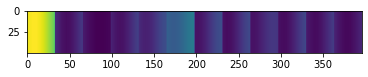

In [56]:
analyzeMistakes(mistakes)

The mistake was between class 0 and 7, but confidence wasn't super high. Plotting these gives some insight into the error

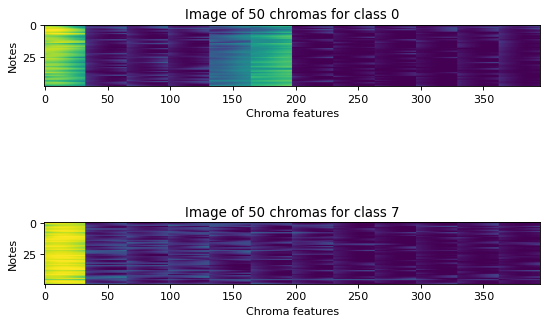

In [57]:
figure(figsize=(8, 6), dpi=80)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax2.imshow(chromas8[1:50][:])
ax2.set_title("Image of 50 chromas for class 7")
ax2.set_xlabel("Chroma features")
ax2.set_ylabel("Notes")
ax1.set_title("Image of 50 chromas for class 0")
ax1.set_xlabel("Chroma features")
ax1.set_ylabel("Notes")
ax1.imshow(chromas1[1:50][:])

Looking at the chromas from the actual classes, that one mistake makes sense. The note that the model is struggling with looks pretty similar to class 7 notes.